In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import io, measure
import napari

import nibabel as nib

import tensorflow as tf
import cv2
import glob
import numpy as np
from meshlib import mrmeshpy as mm
from meshlib import mrmeshnumpy as mn
import keras
import meshplot as mp
from keras import layers
import albumentations as alb
import plotly.graph_objects as go

os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

C:\Users\Lenovo\anaconda3\envs\DL\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Segmentation Models: using `tf.keras` framework.


In [31]:
liver_file = "images/liver_101.nii"
liver_lab = "mask/lab_liver_101.nii"
pred_mask = 'output_volume.nii'

liver_file = io.imread(liver_file)
liver_lab = io.imread(liver_lab)
pred_liver = io.imread(pred_mask)


In [3]:
print(liver_file.shape, liver_lab.shape, pred_liver.shape)

(205, 173, 173) (205, 173, 173) (180, 180, 125)


In [4]:
# verts = mn.getNumpyVerts(pred_liver)
# faces = mn.getNumpyFaces(pred_liver.topology)

In [5]:
# verts.shape
# faces.shape

In [6]:
liver_file[0]

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       ...,
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],
      dtype=float32)

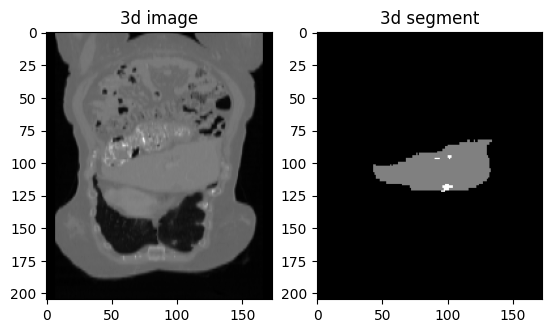

In [7]:
plt.subplot(121)
plt.imshow(liver_file[:, 120, :], cmap="gray")
plt.title("3d image")

plt.subplot(122)
plt.imshow(liver_lab[:, 120, :], cmap="gray")
plt.title("3d segment")

plt.show()

In [40]:
im = napari.view_image(liver_file)
#lab = napari.view_image(liver_lab)
#mask_pred = napari.view_image(tf.transpose(pred_liver))

## Data preparation

In [8]:
image_slices_path = 'image_slices'
mask_slices_path = 'mask_slices'

# variable utils
image_size = (128, 128)
image_shape = (128, 128, 1)
batch_size = 8

filters = [64, 128, 256, 512, 512, 512, 512]
bn = [False, True, True, True, True, True, True]
dropout = [True, True, True, False, False, False]

kernel_size = 4


hounsfield_min = -1000
hounsfield_max = 2000
hounsfield_range = hounsfield_max - hounsfield_min

x_axis = True
y_axis = True
z_axis = False

In [9]:
'''def resize_fn(im):
    len_slices = im.shape[0]
    for i in len_slices:
        single_im = tf.image.resize(im[i], (256, 256))'''



def normalize_vol(vol):
    vol[vol < hounsfield_min] = hounsfield_min
    vol[vol > hounsfield_max] = hounsfield_max
    return (vol - hounsfield_min) / hounsfield_range

def load_vol(vol_path, normalize=False):
    file_num = vol_path.split("_")[-1]
    loaded_vol = io.imread(vol_path)

    if normalize:
        return normalize_vol(loaded_vol), file_num

    return loaded_vol, file_num


def saveslices(fname, im):
    cv2.imwrite(fname, im)

def extract_slices(vol, fname, file_num):
    (dim_z, dim_x, dim_y) = vol.shape
    
    vol = vol * 255

    count = 0
    if x_axis:
        count += dim_x
        for i in range(dim_x):
            x_slice = vol[:, i, :]
            saveslices(f"{fname}/slice_x_{i}.jpg", x_slice)

    if y_axis:
        count += dim_y
        for i in range(dim_y):
            y_slice = vol[:, :, i]
            saveslices(f"{fname}/slice_y_{i}.jpg", y_slice)

    if z_axis:
        count += dim_z
        for i in range(dim_z):
            z_slice = vol[i, :, :]
            saveslices(f"{fname}/slice_z_{i}.jpg", z_slice)

    return count


def get_filename(file):
    filename = file.split('.')[0].split('\\')[-1]
    return filename


In [10]:
v = glob.glob("images/*.nii")

get_filename(v[0])

'liver_0'

In [11]:
# for file in v:
#     filename = get_filename(file)
#     if not os.path.exists(f"{image_slices_path}/{filename}"):
#         os.mkdir(f"{image_slices_path}/{filename}")

In [11]:
for file in glob.glob("images/*.nii"):
    filename = get_filename(file)
    if not os.path.exists(f"{image_slices_path}/{filename}"):
        os.mkdir(f"{image_slices_path}/{filename}")
        print(f"[+] {image_slices_path}/{filename} created")
        loaded_vol, file_num = load_vol(file, normalize=True)
        count = extract_slices(loaded_vol, f"{image_slices_path}/{filename}", file_num)

for file in glob.glob("mask/*.nii"):
    filename = get_filename(file)
    if not os.path.exists(f"{mask_slices_path}/{filename}"):
        os.mkdir(f"{mask_slices_path}/{filename}")
        print(f"[+] {mask_slices_path}/{filename} created")
        loaded_vol, file_num = load_vol(file)
        lab_count = extract_slices(loaded_vol, f"{mask_slices_path}/{filename}", file_num)

## Data loading

In [13]:
slices_im = glob.glob(f"{image_slices_path}/*/*.jpg")
slices_mask = glob.glob(f"{mask_slices_path}/*/*.jpg")

dataset = tf.data.Dataset.from_tensor_slices((slices_im, slices_mask))

In [14]:
for i in dataset.take(10):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_0.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask_slices\\lab_liver_0\\slice_x_0.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_1.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask_slices\\lab_liver_0\\slice_x_1.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_10.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask_slices\\lab_liver_0\\slice_x_10.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_100.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask_slices\\lab_liver_0\\slice_x_100.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_101.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'mask_slices\\lab_liver_0\\slice_x_101.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'image_slices\\liver_0\\slice_x_102.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b

In [15]:
# augmentor = alb.Compose([
#     alb.Resize(128, 128),
#     alb.HorizontalFlip(),
#     alb.Rotate(),
#     alb.Normalize(),
# ])

In [16]:
def load_images(image, mask):
    im, mask = tf.io.read_file(image), tf.io.read_file(mask)
    im, mask = tf.io.decode_jpeg(im), tf.io.decode_jpeg(mask)
    im, mask  = tf.image.resize(im, image_size), tf.image.resize(mask, image_size)
    im, mask = im, mask / 255
    return tf.reshape(im, image_shape), tf.reshape(mask, image_shape)

In [17]:
ds = dataset.map(load_images).shuffle(buffer_size=100)

In [18]:
for im, lab in ds.take(1):
    print(np.min(im), np.max(im), np.max(lab), np.min(lab))

0.0 86.357605 0.0 0.0


In [15]:
preprocess_input = sm.get_preprocessing('resnet18')

In [20]:
augment = layers.RandomContrast(0.7)

In [21]:
def prep(ds):
    ds = ds.map(lambda x, y: (augment(preprocess_input(x)), y))

    return ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [22]:
train_ds = prep(ds)

(8, 128, 128, 1) (8, 128, 128, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


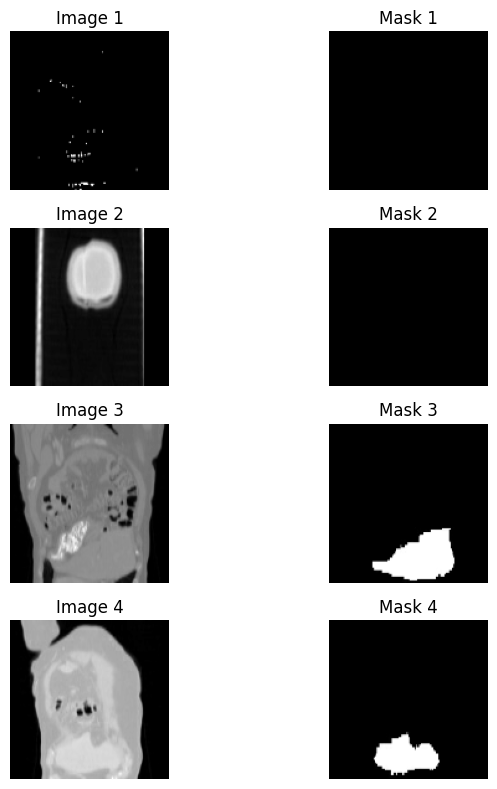

In [23]:
plt.figure(figsize=(8, 8))
for im, mask in train_ds.take(1):
    print(im.shape, mask.shape)
    
    for i in range(4):
        plt.subplot(4, 2, 2 * i + 1)
        print(type(im[i]))
        print(type(mask[i]))
        plt.imshow(im[i], cmap='gray')  # Display the image
        plt.title(f"Image {i+1}")
        plt.axis('off')
    
        plt.subplot(4, 2, 2 * i + 2)
        plt.imshow(mask[i], cmap='gray')  # Display the mask
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
      

In [24]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

## Building the 2D Unet

In [25]:
# def downsample(filters, k_size, bn=True):
#     model = keras.Sequential()
#     model.add(layers.Conv2D(filters, k_size, padding="same", use_bias=False))
#     if bn:
#         model.add(layers.BatchNormalization())
        
#     model.add(layers.LeakyReLU()) 
#     model.add(layers.MaxPooling2D(2, 2))
    
#     def apply(x):
#         x = model(x)
#         return x

#     return apply

In [26]:
# test = tf.random.normal([1, 256, 256, 1])
# x = downsample(64, 4)(test)
# x.shape

In [27]:
# def upsample(filters, k_size, dropout=False):
#     model = keras.Sequential()
#     model.add(layers.Conv2DTranspose(filters, k_size, strides=(2, 2), padding="same"))
#     if dropout:
#         model.add(layers.Dropout(0.25))

#     model.add(layers.ReLU())

#     def apply(x):
#         x = model(x)
#         return x

#     return apply

In [28]:
# x = upsample(1, 4)(x)
# x.shape

In [29]:
# def Unet():
#     inputs = layers.Input(shape=image_shape)
#     x = inputs
#     skip = []
    
#     for f, b in zip(filters, bn):
#         x = downsample(f, kernel_size, b)(x)
#         skip.append(x)

#     for f, a, sk in zip(reversed(filters[:-1]), dropout, reversed(skip[:-1])):
#         x = upsample(f, kernel_size, a)(x)
#         x = layers.Concatenate()([x, sk])

#     final_layer = layers.Conv2DTranspose(1, 4, strides=(2, 2), activation="sigmoid", padding="same")(x)

#     model = keras.Model(inputs, final_layer)
#     return model

In [30]:

unet_model = sm.Unet(backbone_name='resnet18', input_shape=image_shape, classes=1, encoder_weights=None)
unet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)             │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_data (BatchNormalization)  │ (None, 128, 128, 1)       │               3 │ data[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 134, 134, 1)       │               0 │ bn_data[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv0 (Conv2D)                │ (None, 64, 64, 64)        │           3,136 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn0 (BatchNormalization)      │ (None, 64, 64, 64)        │             256 │ conv0[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relu0 (Activation)            │ (None, 64, 64, 64)        │               0 │ bn0[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 66, 66, 64)        │               0 │ relu0[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooling0 (MaxPooling2D)       │ (None, 32, 32, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn1              │ (None, 32, 32, 64)        │             256 │ pooling0[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu1            │ (None, 32, 32, 64)        │               0 │ stage1_unit1_bn1[0][0]     │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 34, 34, 64)        │               0 │ stage1_unit1_relu1[0][0]   │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_conv1 (Conv2D)   │ (None, 32, 32, 64)        │          36,864 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn2              │ (None, 32, 32, 64)        │             256 │ stage1_unit1_conv1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu2            │ (None, 32, 32, 64)        │               0 │ stage1_unit1_bn2[0][0]     │
│ (Activation)                  │                           │               

 Total params: 14,334,292 (54.68 MB)

 Trainable params: 14,324,370 (54.64 MB)

 Non-trainable params: 9,922 (38.76 KB)

In [31]:
unet_model.compile(loss = keras.losses.BinaryCrossentropy(),
             optimizer = keras.optimizers.Adam(),
             metrics=['Accuracy'])

In [ ]:
history = unet_model.fit(train_ds, epochs=20)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 229s 697ms/step - Accuracy: 0.9367 - loss: 0.2012
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 190s 688ms/step - Accuracy: 0.9749 - loss: 0.0443
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 189s 686ms/step - Accuracy: 0.9771 - loss: 0.0361
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 188s 680ms/step - Accuracy: 0.9789 - loss: 0.0291
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 190s 688ms/step - Accuracy: 0.9803 - loss: 0.0265
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 191s 690ms/step - Accuracy: 0.9805 - loss: 0.0253
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 188s 682ms/step - Accuracy: 0.9816 - loss: 0.0211
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 188s 680ms/step - Accuracy: 0.9820 - loss: 0.0202
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 187s 677ms/step - Accuracy: 0.9836 - loss: 0.0146
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 187s 679ms/step - Accuracy: 0.9842 - loss: 0.0124
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 187s 679ms/step - Accuracy: 0.9845 - loss: 0.0109
Epoch 12

In [ ]:
unet_model.save('unet_model.keras')

In [ ]:
test_im, test_mask = ds.as_numpy_iterator().next()
test_im.shape

# Inference

In [4]:
loaded_model = keras.models.load_model('unet_model_2.keras')

In [32]:
def predictVol(volume):
    dimz, dimx, dimy = volume.shape
    outimgx = np.zeros((dimz, dimx, dimy))
    outimgy = np.zeros((dimz, dimx, dimy))
    outimgz = np.zeros((dimz, dimx, dimy))

    volume = normalize_vol(volume)
    volume = volume * 255

    count = 0


    if x_axis:
        print("[+] slicing x axis")
        count += 1
        for i in range(dimx):
            slice_2d = volume[:, i, :][..., tf.newaxis]
            slice_2d = tf.image.resize(slice_2d, image_size)
            slice_2d = preprocess_input(slice_2d)
            pred = loaded_model(slice_2d[tf.newaxis])
            pred = tf.where(pred > 0.5, 1, 0)
            pred = tf.image.resize(pred, (dimz, dimy))
            outimgx[:, i, :] = pred[0, :, :, 0]


    if y_axis:
        print("[+] slicing y axis")
        count += 1
        for i in range(dimy):
            slice_2d = volume[:, :, i][..., tf.newaxis]
            slice_2d = tf.image.resize(slice_2d, image_size)
            slice_2d = preprocess_input(slice_2d)
            pred = loaded_model(slice_2d[tf.newaxis])
            pred = tf.where(pred > 0.5, 1, 0)
            pred = tf.image.resize(pred, (dimz, dimx))
            outimgy[:, :, i] = pred[0, :, :, 0]



    if z_axis:
        print("[+] slicing z axis")
        count += 1
        for i in range(dimz):
            volume = normalize_vol(volume)
            slice_2d = volume[i, :, :][..., tf.newaxis]
            slice_2d = tf.image.resize(slice_2d, image_size)
            slice_2d = preprocess_input(slice_2d)
            pred = loaded_model(slice_2d[tf.newaxis])
            pred = tf.where(pred > 0.5, 1, 0)
            pred = tf.image.resize(pred, (dimx, dimy))
            outimgz[i, :, :] = pred[0, :, :, 0]

    outimg = (outimgx + outimgy + outimgz) / count

    return outimg, outimgx, outimgy, outimgz, count

In [33]:
out_vol, out_volx, out_voly, out_volz, count = predictVol(liver_file)

[+] slicing x axis
[+] slicing y axis


In [34]:
out_vol.shape, out_volx.shape, out_voly.shape, out_volz.shape, count

((160, 181, 181), (160, 181, 181), (160, 181, 181), (160, 181, 181), 2)

In [35]:
np.max(out_vol)

1.0

In [36]:
verts, faces, _, _  = measure.marching_cubes(out_vol)

In [37]:
# transpose for plotly
verts_t, faces_t = np.transpose(verts), np.transpose(faces)

In [38]:
new_verts, new_faces, _, _ = measure.marching_cubes(normalize_vol(liver_file))
new_t, fac_t = np.transpose(new_verts), np.transpose(new_faces)

## Save predicted mask volume

In [22]:
# Define an affine transformation (identity matrix in this case)
affine = np.eye(4)

# Create a NIfTI image
nifti_image = nib.Nifti1Image(out_vol, affine)

# Save the NIfTI image to a file
nib.save(nifti_image, 'output_volume.nii')

print("3D volume saved as 'output_volume.nii'")

3D volume saved as 'output_volume.nii'


In [24]:
im_lab = napari.view_image(liver_lab)
pred_lab = napari.view_image(np.transpose(io.imread('output_volume.nii')))